<a href="https://colab.research.google.com/github/eoinleen/Protein-design-random/blob/main/Seq_analysis_RFdiff_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parsing sequences from FASTA file...
Number of sequences loaded: 2048
Encoding sequences...
Calculating similarity matrix...
Plotting similarity heatmap...


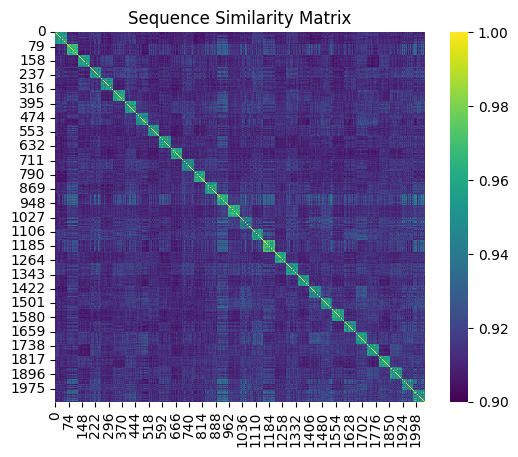

Clustering sequences...
Clusters saved to 'clusters.csv'
                                            Sequence  Cluster
0  SLLAALEKAAKEEEAKKVTAEIEAIMSKITGKEVKLKPLSIDELEE...        2
1  SLLEKKEKEEAEEEAKKFTEEIEKILSELTGKKVTAKPISIEELKE...        2
2  AALAAAAAAAAAAAAAALTARIEAVMSEISGKPVTLKPISIAELNE...        2
3  MLEELQKKLEQLKKAKEFTKEIEKILSAETGKEVKLKLLSIEEYEK...        2
4  GLAALKRLLEELKEAREVTEEIERVYSELTGKKVTLKLMTIEELRE...        2
Visualizing cluster distribution...


<ipython-input-7-623be30c0ede>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=seq_df, x="Cluster", palette="Set2")


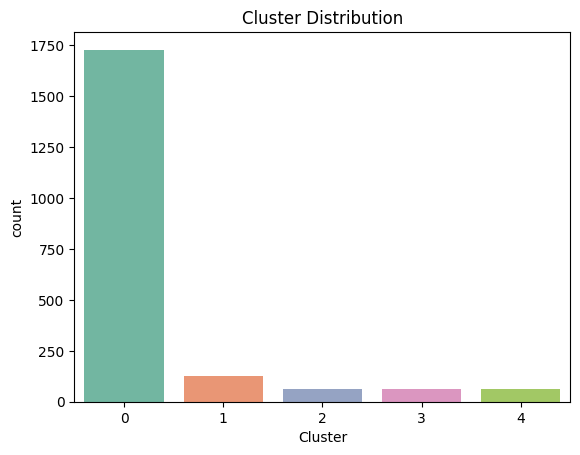

Analyzing positional variability...


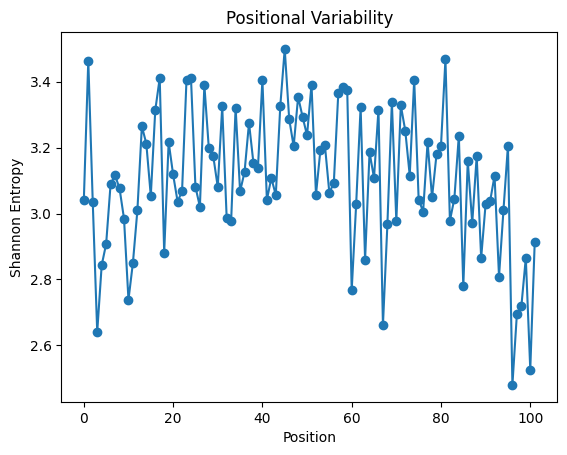

Creating phylogenetic tree...


ValueError: 'names' and 'matrix' should be the same size

In [7]:
# Install required packages
!pip install biopython
!pip install scipy
!pip install seaborn
!pip install matplotlib
!pip install pandas

# Import packages
import os
import numpy as np
import pandas as pd
from Bio import SeqIO, Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

# File path to your FASTA file
fasta_file = "/content/drive/MyDrive/Fasta-files/3NOB_90-110/extracted_sequences.fasta"

# Step 1: Parse FASTA Sequences
print("Parsing sequences from FASTA file...")
sequences = []
sequence_names = []
for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq))
    sequence_names.append(record.id)

print(f"Number of sequences loaded: {len(sequences)}")

# Step 2: One-Hot Encode Sequences
def one_hot_encode(seq_list):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Standard amino acids
    encoding = np.zeros((len(seq_list), len(seq_list[0]), len(amino_acids)))
    for i, seq in enumerate(seq_list):
        for j, char in enumerate(seq):
            if char in amino_acids:
                encoding[i, j, amino_acids.index(char)] = 1
    return encoding.reshape(len(seq_list), -1)

print("Encoding sequences...")
encoded_seqs = one_hot_encode(sequences)

# Step 3: Compute Pairwise Similarity Matrix
print("Calculating similarity matrix...")
dist_matrix = pdist(encoded_seqs, metric="hamming")
sim_matrix = 1 - squareform(dist_matrix)  # Similarity is 1 - distance

# Step 4: Visualize Similarity Heatmap
print("Plotting similarity heatmap...")
sns.heatmap(sim_matrix, cmap="viridis", square=True)
plt.title("Sequence Similarity Matrix")
plt.show()

# Step 5: Cluster Sequences
print("Clustering sequences...")
cluster = AgglomerativeClustering(metric='precomputed', linkage='average', n_clusters=5)
labels = cluster.fit_predict(1 - sim_matrix)

# Save cluster results
cluster_df = pd.DataFrame({'Sequence': sequences, 'Cluster': labels})
cluster_df.to_csv('/content/clusters.csv', index=False)
print("Clusters saved to 'clusters.csv'")

# Add labels to sequences
seq_df = pd.DataFrame({'Sequence': sequences, 'Cluster': labels})
print(seq_df.head())

# Step 6: Visualize Cluster Distribution
print("Visualizing cluster distribution...")
sns.countplot(data=seq_df, x="Cluster", palette="Set2")
plt.title("Cluster Distribution")
plt.show()

# Step 7: Analyze Positional Variability
print("Analyzing positional variability...")
def calculate_positional_entropy(seqs):
    variability = []
    for pos in range(len(seqs[0])):
        column = [seq[pos] for seq in seqs]
        unique, counts = np.unique(column, return_counts=True)
        entropy = -np.sum((counts / sum(counts)) * np.log2(counts / sum(counts)))
        variability.append(entropy)
    return variability

position_variability = calculate_positional_entropy(sequences)

# Plot Positional Variability
plt.plot(range(len(position_variability)), position_variability, marker="o")
plt.title("Positional Variability")
plt.xlabel("Position")
plt.ylabel("Shannon Entropy")
plt.show()

# Step 8: Create Phylogenetic Tree
print("Creating phylogenetic tree...")
def create_phylogenetic_tree(distance_matrix, sequence_names):
    # Ensure distance matrix is in a lower triangular format
    lower_triangle = []
    for i in range(len(sequence_names)):
        row = []
        for j in range(i):  # Only include elements below the diagonal
            row.append(distance_matrix[i, j])
        lower_triangle.append(row)

    # Convert to Biopython's DistanceMatrix format
    dm = DistanceMatrix(names=sequence_names, matrix=lower_triangle[1:])  # Exclude the empty first row
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(dm)

    # Plot the tree
    Phylo.draw(tree, do_show=False)
    plt.title("Phylogenetic Tree")
    plt.show()

    # Save the tree as a Newick file
    Phylo.write(tree, '/content/phylogenetic_tree.newick', 'newick')
    print("Phylogenetic tree saved to 'phylogenetic_tree.newick'")

# Convert similarity to distance for phylogenetic tree
distance_matrix = 1 - sim_matrix

# Call the function
create_phylogenetic_tree(distance_matrix, sequence_names)


# Step 9: Save Results
output_file = "/content/drive/MyDrive/Fasta-files/clustered_sequences.csv"
print(f"Saving results to {output_file}...")
seq_df.to_csv(output_file, index=False)

print("Analysis complete.")
